# Homework 8: Clustering

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

## Mall Customers Dataset

In this assignment, you will work on customer segmentation using clustering techniques.

The dataset for this assignment is the **Mall Customers Dataset**, which contains customer data collected from a shopping mall. It includes:

- **CustomerID**: Unique identifier for each customer (not useful for clustering).
- **Gender**: Male or Female.
- **Age**: Age of the customer.
- **Annual Income (k$)**: Annual income in thousands of dollars.
- **Spending Score (1-100)**: A metric indicating customer spending habits.

The goal is to segment customers based on their characteristics using different clustering methods.


In [123]:
import numpy as np
import polars as pl
import pandas as pd

# Clustering
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

# Plotting
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

1. Load the CSV file. Display the summary statistics for the dataset and check if there are any null values in the dataset. Use polars unless your operators do not allow it (transforming them to pandas or numpy at that stage).

In [124]:
# YOUR CODE HERE
mall = pl.read_csv("Mall_Customers.csv")
mall.describe()

statistic,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
str,f64,str,f64,f64,f64
"""count""",200.0,"""200""",200.0,200.0,200.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0
"""mean""",100.5,null,38.85,60.56,50.2
"""std""",57.879185,null,13.969007,26.264721,25.823522
"""min""",1.0,"""Female""",18.0,15.0,1.0
"""25%""",51.0,null,29.0,42.0,35.0
"""50%""",101.0,null,36.0,62.0,50.0
"""75%""",150.0,null,49.0,78.0,73.0
"""max""",200.0,"""Male""",70.0,137.0,99.0


In [125]:
# YOUR CODE HERE
print(mall.head())
print(mall.unique(subset=["Genre"]))


shape: (5, 5)
┌────────────┬────────┬─────┬────────────────────┬────────────────────────┐
│ CustomerID ┆ Genre  ┆ Age ┆ Annual Income (k$) ┆ Spending Score (1-100) │
│ ---        ┆ ---    ┆ --- ┆ ---                ┆ ---                    │
│ i64        ┆ str    ┆ i64 ┆ i64                ┆ i64                    │
╞════════════╪════════╪═════╪════════════════════╪════════════════════════╡
│ 1          ┆ Male   ┆ 19  ┆ 15                 ┆ 39                     │
│ 2          ┆ Male   ┆ 21  ┆ 15                 ┆ 81                     │
│ 3          ┆ Female ┆ 20  ┆ 16                 ┆ 6                      │
│ 4          ┆ Female ┆ 23  ┆ 16                 ┆ 77                     │
│ 5          ┆ Female ┆ 31  ┆ 17                 ┆ 40                     │
└────────────┴────────┴─────┴────────────────────┴────────────────────────┘
shape: (2, 5)
┌────────────┬────────┬─────┬────────────────────┬────────────────────────┐
│ CustomerID ┆ Genre  ┆ Age ┆ Annual Income (k$) ┆ Spending 

2. For the clustering analyses, consider only the numerical variables. Therefore you should drop 'Genre' from the dataset. Standardize the remaining variables, excluding the ID, ensuring they have mean of zero and standard deviation of one.

In the following lines you should:

- Update the dataset to include only numerical features and display the first 10 rows of the updated dataset.

- Standardize the features.

In [126]:
# YOUR CODE HERE
mall = mall.drop("CustomerID")
mall = mall.drop("Genre")
mall.head(10)

Age,Annual Income (k$),Spending Score (1-100)
i64,i64,i64
19,15,39
21,15,81
20,16,6
23,16,77
31,17,40
22,17,76
35,18,6
23,18,94
64,19,3


In [127]:
# YOUR CODE HERE
scaler = StandardScaler()
mall = pl.DataFrame(scaler.fit_transform(mall), schema=mall.schema)

## K-means

3. Use the K-means method to perform clustering on the scaled data from Q2, setting `random_state = 2025`. Determine the optimal number of clusters using the [KelbowVisualizer](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html)  function with `k=(2,12)`.



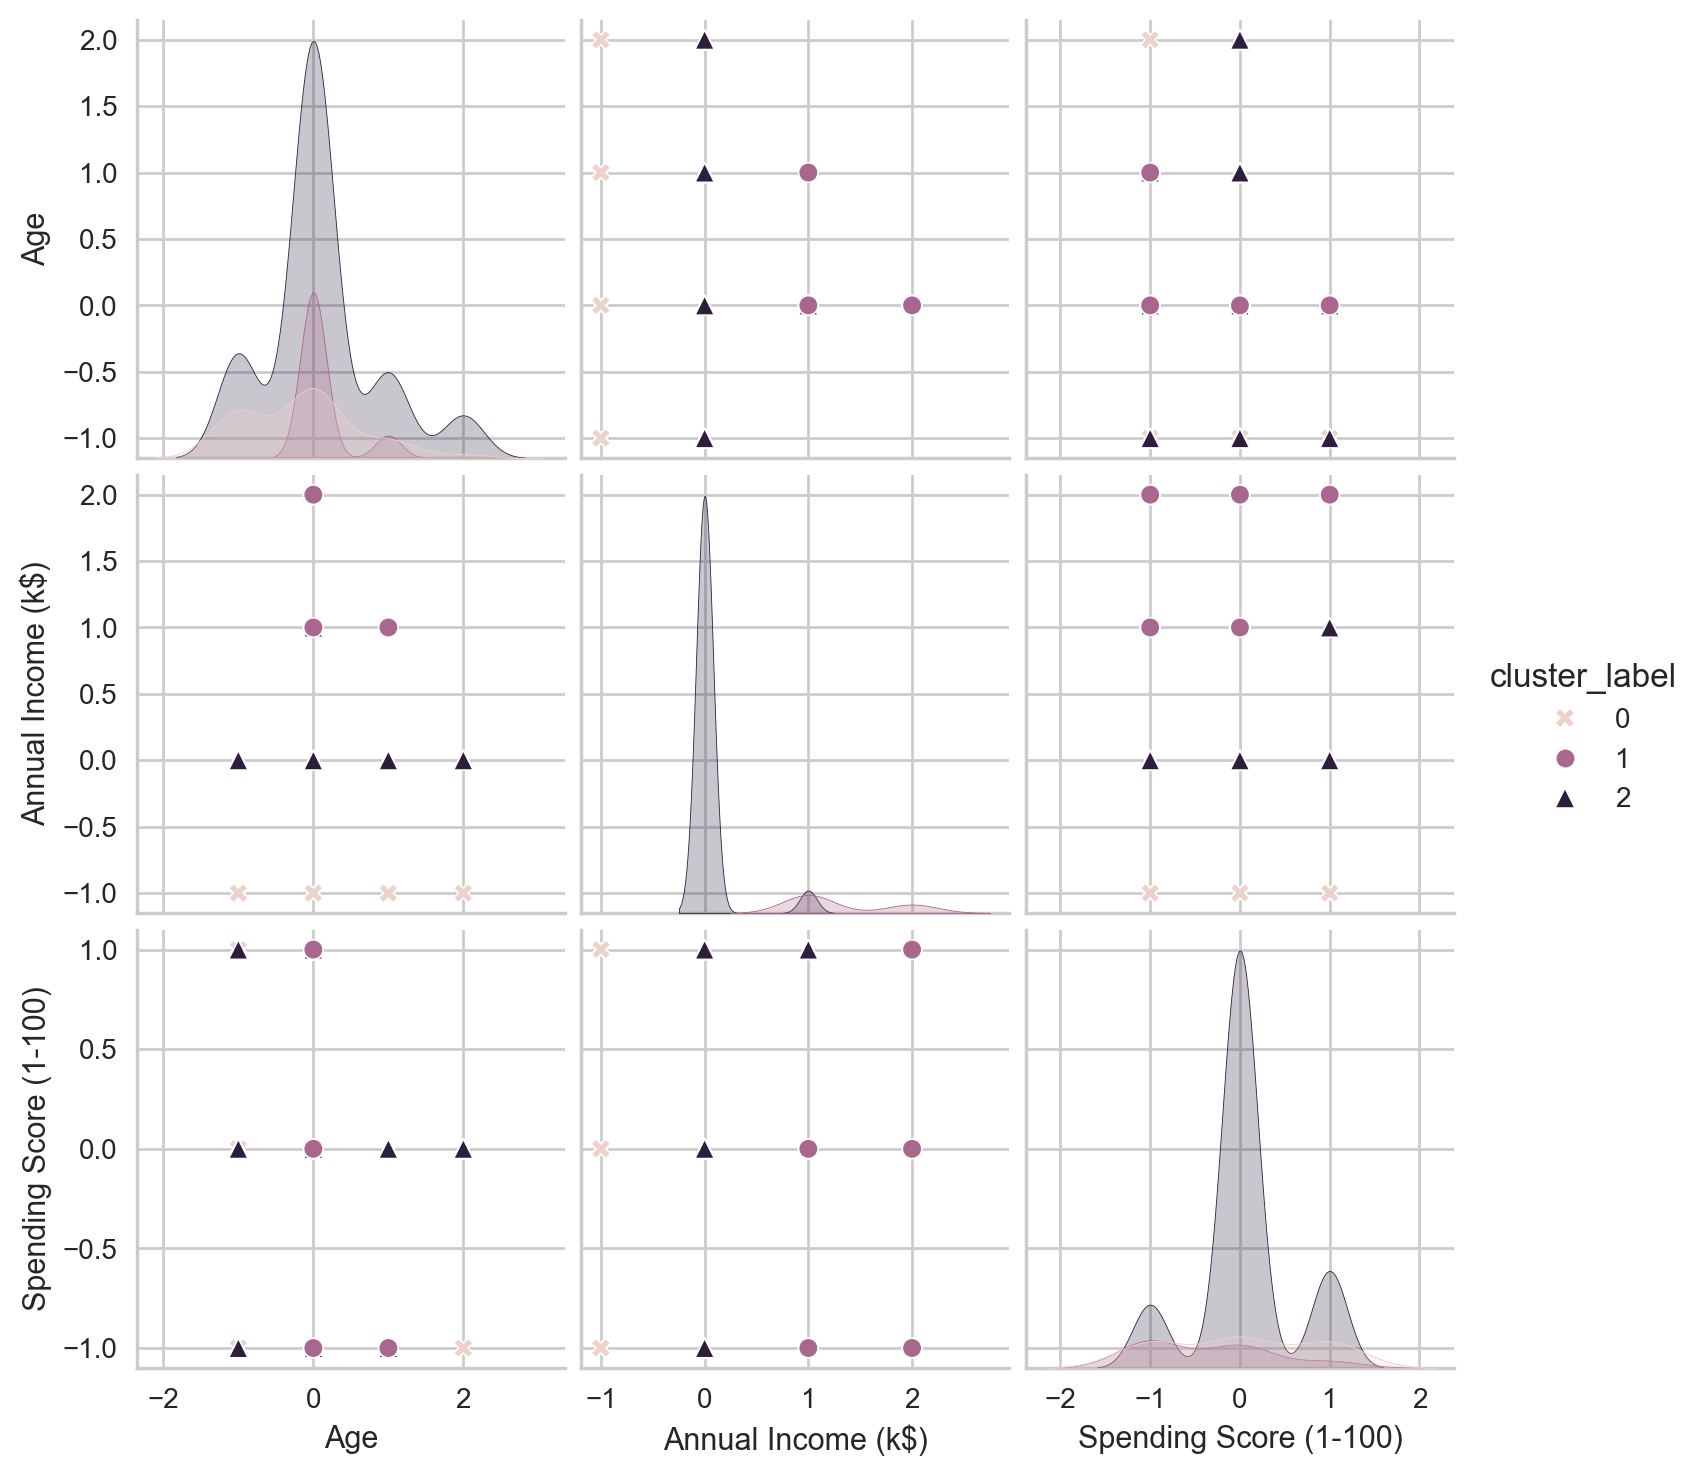

In [128]:
# YOUR CODE HERE
KClusterer = KMeans(n_clusters=3,
                   verbose=0,
                   random_state=2025) # Name of operator and cluster number

mall2 = mall.with_columns(pl.Series("cluster_label",KClusterer.fit_predict(mall.to_numpy())))


sns.pairplot(vars=mall.columns, # Variable names
             hue='cluster_label',        # How to colour the points. Use cluster labels
             markers=['X','o','^'],      # Differentiate markers
             data=mall2.to_pandas(),                     # What data to use
            )

plt.show()



<bound method Visualizer.show of KElbowVisualizer(ax=<Axes: >,
                 estimator=KMeans(n_clusters=11, random_state=2025), k=(2, 12),
                 timings=False)>

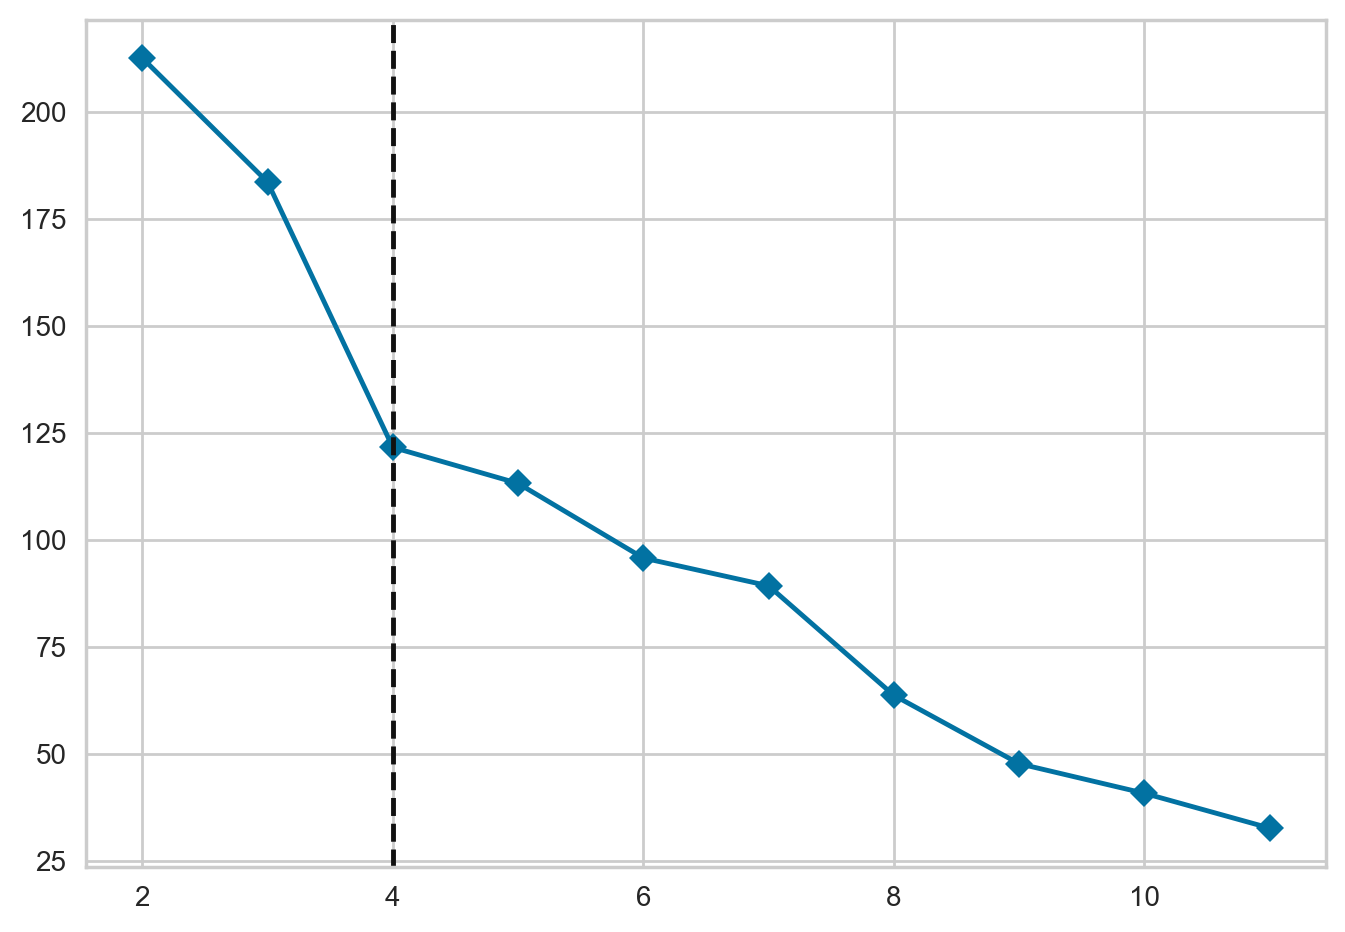

In [129]:
visualizer = KElbowVisualizer(KClusterer,
                              k=(2,12),
                              locate_elbow=True,
                              timings=False)

visualizer.fit(mall.to_numpy())
visualizer.show


**Written answer: What is the optimal number of clusters using the elbow method?** 

**ANSWER HERE:** The optimal number of clusters using the elbow method is 4 clusters

4. Fit a K-means model on the scaled data using the optimal number of clusters identified in Q3. Then, visualize the resulting clusters using a scatterplot matrix (`sns.pairplot`).

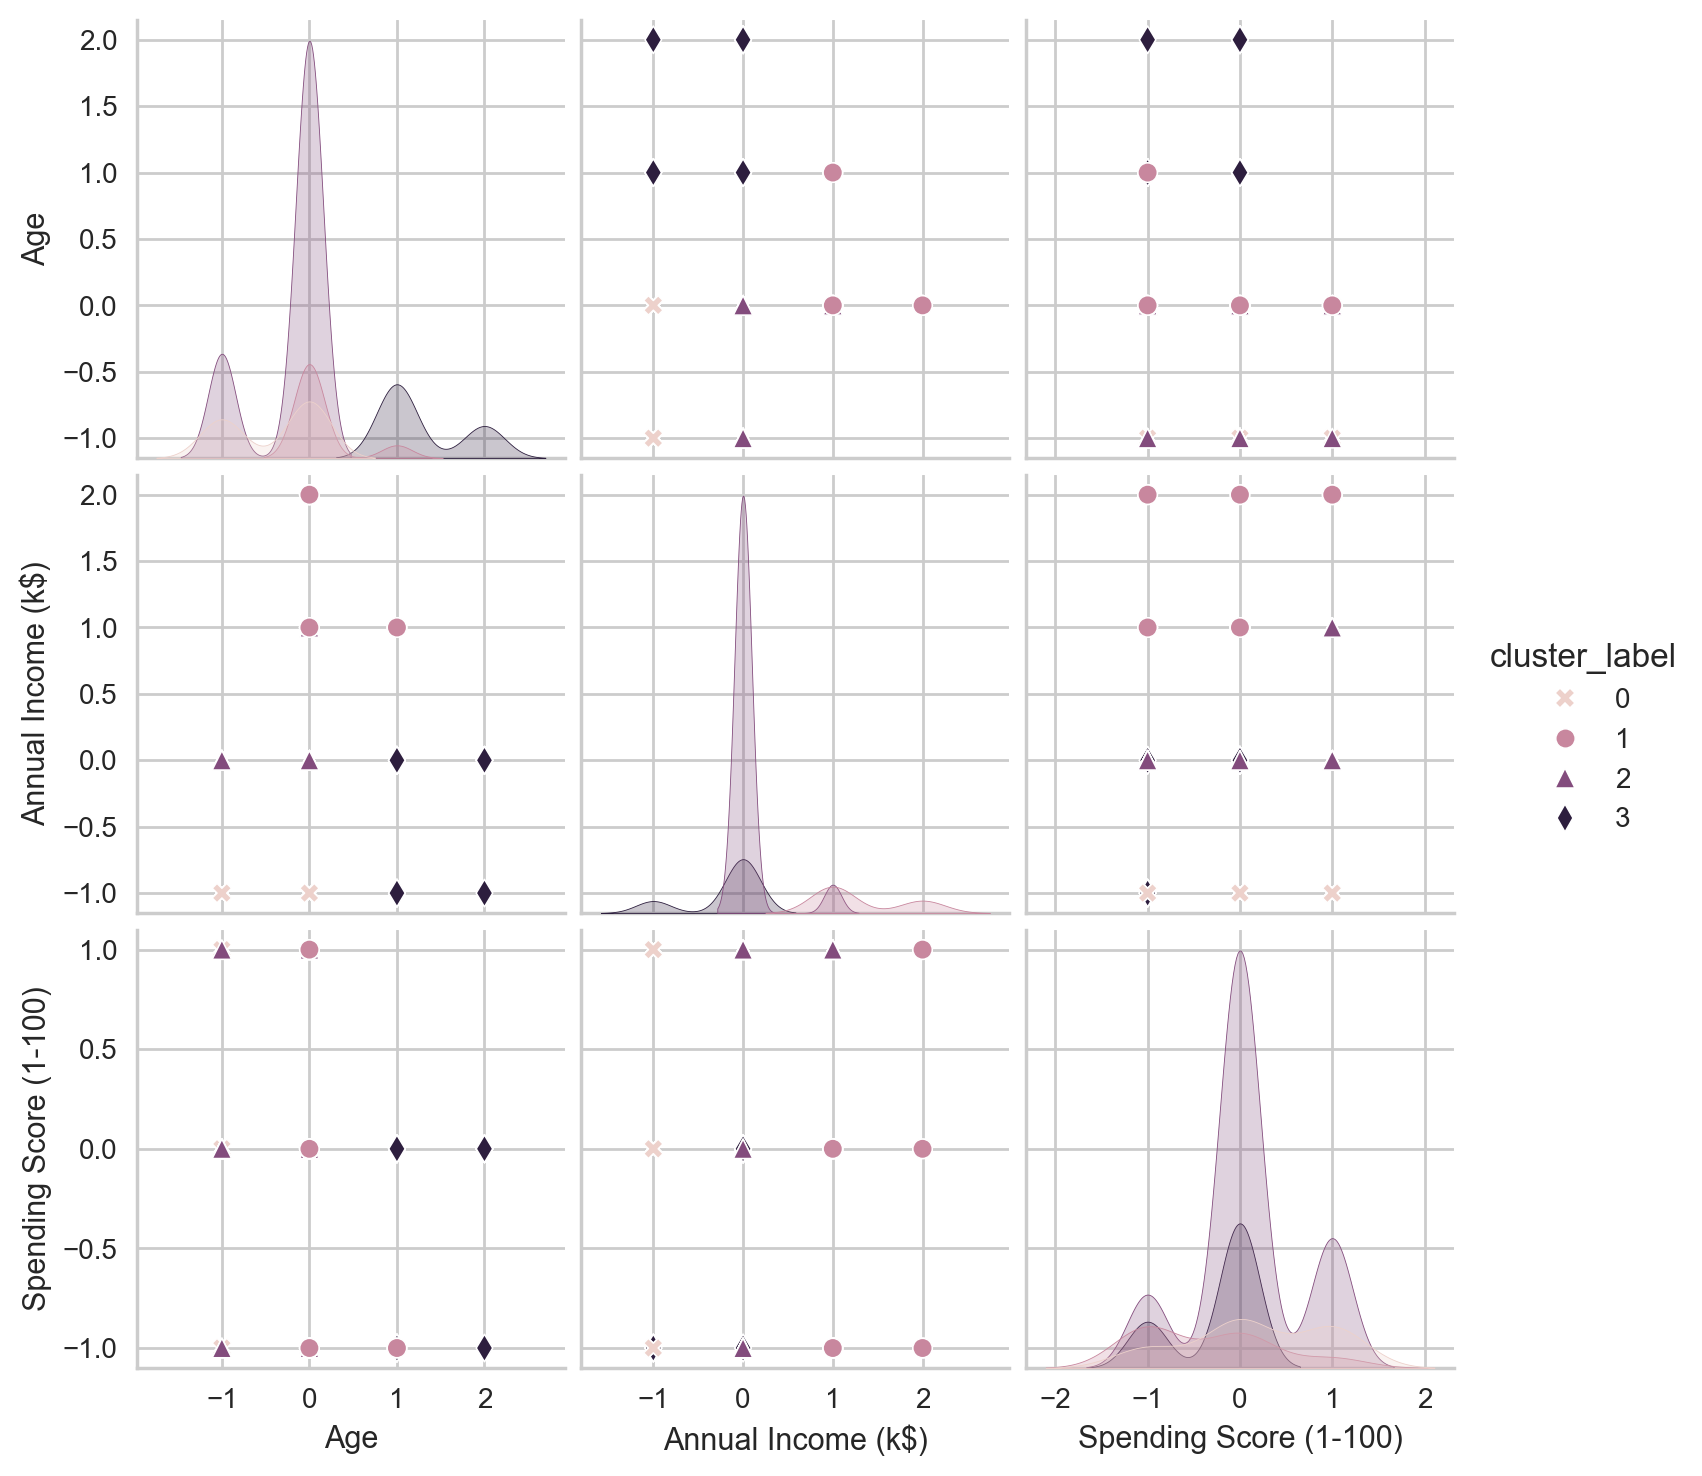

In [132]:
# YOUR CODE HERE
KClusterer = KMeans(n_clusters=4,
                    verbose=0,
                    random_state=2025)
mall2 = mall.with_columns(pl.Series("cluster_label",KClusterer.fit_predict(mall.to_numpy())))

sns.pairplot(vars=mall.columns, # Variable names
             hue='cluster_label',        # How to colour the points. Use cluster labels
             markers=['X','o','^', 'd'],      # Differentiate markers
             data=mall2.to_pandas(),                     # What data to use
            )

plt.show()

5. The objective of any cluster analysis over customer data is to create a reasonable segmentation of your customers. Using the clusters from Q4, create a table showing the average values per variable (Age, Annual income, and Spending scores) for each cluster. Use the original, non-scaled variables. Interpret the characteristics of each cluster by analyzing their defining features, such as whether they represent high-income spenders, budget-conscious customers, or younger versus older groups.

In [ ]:
# YOUR CODE HERE

**Written answer:**


## Agglomerative clustering

6. Use Agglomerative Clustering with `linkage='average'` to determine the best number of clusters (between 3 and 7) using silhouette analysis.

For each number of clusters:

- Compute and print the average silhouette score.
- Generate and display a silhouette plot.

In [ ]:
# YOUR CODE HERE
AgglomerativeIris = AgglomerativeClustering(n_clusters=4,         # Number of clusters
                                            metric="euclidean",    # Distance metric
                                            linkage="average"      # Type of linkage.
                                            )

**Written Answer:** How many clusters were select based on the Silhouette analysis? Explain your answer.

**ANSWER HERE:**

7. Fit the Agglomerative clustering on the scaled data using the optimal number of clusters identified in Q6. Then, visualize the resulting clusters using scatterplots.

In [ ]:
# YOUR CODE HERE

8. Using the clusters from Q7, create a table showing the average values per variable (Age, Annual income, and Spending scores) for each cluster. Use the original, non-scaled variables. Interpret the characteristics of each cluster.

In [ ]:
# YOUR CODE HERE

**Written answer:**


## Spectral Clustering

9. Use Spectral Clustering to determine the best number of clusters (between 3 and 8) using silhouette analysis.

Set the parameters:
- `affinity = 'nearest_neighbors'`
- `n_jobs = -1`
- `n_neighbors = 10`
- `random_state = 2025`


For each number of clusters:

- Compute and display the average silhouette score
- Generate the silhouette plot.



In [ ]:
# YOUR CODE HERE

**Written Answer:** How many clusters were select based on the Silhouette analysis? Explain your answer.

**Written answer:**

10. Fit a Spectral Clustering on the scaled data using the optimal number of clusters identified in Q9. Then, visualize the resulting clusters using scatterplots.

In [ ]:
# YOUR CODE HERE

11. Using the clusters from Q10, create a table showing the average values per variable (Age, Annual income, and Spending scores) for each cluster. Use the original, non-scaled variables. Interpret the characteristics of each cluster.

In [ ]:
# YOUR CODE HERE

**Written answer:**

12. Compare the results obtained using the Agglomerative Clustering and the Spectral Clustering methods. Comment your findings.

**Written answer:**